In [1]:
import os
import numpy as np
import pandas as pd
import math
import cv2
import sklearn
import tensorflow as tf
import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPool2D,Concatenate,Add,Dropout,ReLU,Conv2DTranspose,UpSampling2D

In [2]:
image_path = 'lungs_data/2d_images'
mask_path = 'lungs_data/2d_masks'

In [3]:
autotune = tf.data.experimental.AUTOTUNE
image_size = 448
batch_size = 16

In [4]:
exclude = [image_path+'/ID_0254_Z_0075.tif',mask_path+'/ID_0254_Z_0075.tif',
           image_path+'/ID_0052_Z_0108.tif',mask_path+'/ID_0052_Z_0108.tif',
           image_path+'/ID_0079_Z_0072.tif',mask_path+'/ID_0079_Z_0072.tif',
           image_path+'/ID_0134_Z_0137.tif',mask_path+'/ID_0134_Z_0137.tif']

num_files = len(os.listdir(image_path))-len(exclude)/2
print(num_files)

def read_image(image):
    path = image.numpy().decode('utf-8')
    if path not in exclude:
        image = cv2.imread(path,0)
        image = np.expand_dims(image,2)
        image = tf.image.resize(image, [image_size,image_size])
    else:
        image = np.zeros((image_size,image_size,1),dtype=np.float32)
    return image

def read_mask(image):
    path = image.numpy().decode('utf-8')
    if path not in exclude:
        image = cv2.imread(path,0)
        image = image*257.
        image = np.expand_dims(image,2)
        image = tf.image.resize(image, [image_size,image_size])
    else:
        image = np.zeros((image_size,image_size,1),dtype=np.float32)
    return image

def aug(image,label):
    seed = np.random.randint(0,64)
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    image = tf.image.random_contrast(image, 0.3, 0.7, seed=seed)
    label = tf.image.random_flip_left_right(label, seed=seed)
    label = tf.image.random_flip_up_down(label, seed=seed)
    label = tf.image.random_contrast(label, 0.3, 0.7, seed=seed)
    return image,label

dataset_image = tf.data.Dataset.list_files('../input/finding-lungs-in-ct-data/2d_images/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_image,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)
dataset_mask = tf.data.Dataset.list_files('../input/finding-lungs-in-ct-data/2d_masks/*.tif',shuffle=False,seed=None).map(lambda x: tf.py_function(read_mask,[x],[tf.float32]),num_parallel_calls=autotune,deterministic=False)

dataset = tf.data.Dataset.zip((dataset_image, dataset_mask))
dataset = dataset.repeat().shuffle(128).batch(batch_size).cache().prefetch(autotune)
train = dataset.take(int(0.8*num_files//batch_size))
test = dataset.skip(int(0.8*num_files//batch_size))

263.0


2022-09-20 22:56:38.811349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 22:56:38.916201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 22:56:38.917120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-20 22:56:38.920056: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
keep_scale = 0.2
l1l2 = tf.keras.regularizers.l1_l2(l1=0, l2=0.0005)

def resblock(x,level='en_l1',filters=64,keep_scale=keep_scale,l1l2=l1l2,downsample=False,bn_act=True,first_layer=False):
    if downsample:
        if not first_layer:
            x_H = Conv2D(filters,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name=level+'_Hconv')(x)
            x = Conv2D(filters/2,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv1')(x)
        else:
            x_H = Conv2D(filters,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name=level+'_Hconv')(x)
            x = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv1')(x)
    else:
        x_H = x
        x = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv1')(x)
    x = BatchNormalization(name=level+'_conv1bn')(x)
    x = ReLU(name=level+'_conv1relu')(x)
    if downsample:
        x = Conv2D(filters,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name=level+'_conv2')(x)
    else:
        x = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l1l2,name=level+'_conv2')(x)
    x = BatchNormalization(name=level+'_conv2bn')(x)
    x = ReLU(name=level+'_conv2relu')(x)
    x = Add(name=level+'_add')([x_H*keep_scale,x*(1-keep_scale)])
    if bn_act:
        x = BatchNormalization(name=level+'_finalbn')(x)
        x = ReLU(name=level+'_finalrelu')(x)       
    return x

In [6]:
inputs = tf.keras.Input(shape=(image_size,image_size,1),name='input')

layer_0 = Conv2D(64,(7,7),strides=(2,2),padding='same',name='input_conv1',activation=None)(inputs)
layer = BatchNormalization(name='input_conv1bn')(layer_0)
layer = ReLU(name='input_conv1relu')(layer)

## Encoder
layer = resblock(layer,'en_l1',64,keep_scale,l1l2,downsample=True,bn_act=True,first_layer=True)
layer = resblock(layer,'en_l2',64,keep_scale,l1l2,downsample=False,bn_act=True)
encoder_1 = resblock(layer,'en_l3',64,keep_scale,l1l2,downsample=False,bn_act=False)
layer = BatchNormalization(name='en_l3_finalbn')(encoder_1)
layer = ReLU(name='en_l3_finalrelu')(layer)

layer = resblock(layer,'en_l4',128,keep_scale,l1l2,downsample=True,bn_act=True)
layer = resblock(layer,'en_l5',128,keep_scale,l1l2,downsample=False,bn_act=True)
layer = resblock(layer,'en_l6',128,keep_scale,l1l2,downsample=False,bn_act=True)
encoder_2 = resblock(layer,'en_l7',128,keep_scale,l1l2,downsample=False,bn_act=False)
layer = BatchNormalization(name='en_l7_finalbn')(encoder_2)
layer = ReLU(name='en_l7_finalrelu')(layer)

layer = resblock(layer,'en_l8',256,keep_scale,l1l2,downsample=True,bn_act=True)
layer = resblock(layer,'en_l9',256,keep_scale,l1l2,downsample=False,bn_act=True)
layer = resblock(layer,'en_l10',256,keep_scale,l1l2,downsample=False,bn_act=True)
layer = resblock(layer,'en_l11',256,keep_scale,l1l2,downsample=False,bn_act=True)
layer = resblock(layer,'en_l12',256,keep_scale,l1l2,downsample=False,bn_act=True)
encoder_3 = resblock(layer,'en_l13',256,keep_scale,l1l2,downsample=False,bn_act=False)
layer = BatchNormalization(name='en_l13_finalbn')(encoder_3)
layer = ReLU(name='en_l13_finalrelu')(layer)

layer = resblock(layer,'en_l14',512,keep_scale,l1l2,downsample=True,bn_act=True)
layer = resblock(layer,'en_l15',512,keep_scale,l1l2,downsample=False,bn_act=True)
layer = resblock(layer,'en_l16',512,keep_scale,l1l2,downsample=False,bn_act=True)

## DAC block
b1 = Conv2D(512,(3,3),padding='same',dilation_rate=1,name='dac_b1_conv1',activation=None)(layer)
# b1 = BatchNormalization()(b1)
# b1 = ReLU(name='dac_b1_relu')(b1)

b2 = Conv2D(512,(3,3),padding='same',dilation_rate=3,name='dac_b2_conv1',activation=None)(layer)
b2 = Conv2D(512,(1,1),padding='same',dilation_rate=1,name='dac_b2_conv2',activation=None)(b2)
# b2 = BatchNormalization()(b2)
# b2 = ReLU(name='dac_b2_relu')(b2)

b3 = Conv2D(512,(3,3),padding='same',dilation_rate=1,name='dac_b3_conv1',activation=None)(layer)
b3 = Conv2D(512,(3,3),padding='same',dilation_rate=3,name='dac_b3_conv2',activation=None)(b3)
b3 = Conv2D(512,(1,1),padding='same',dilation_rate=1,name='dac_b3_conv3',activation=None)(b3)
# b3 = BatchNormalization()(b3)
# b3 = ReLU(name='dac_b3_relu')(b3)

b4 = Conv2D(512,(3,3),padding='same',dilation_rate=1,name='dac_b4_conv1',activation=None)(layer)
b4 = Conv2D(512,(3,3),padding='same',dilation_rate=3,name='dac_b4_conv2',activation=None)(b4)
b4 = Conv2D(512,(3,3),padding='same',dilation_rate=5,name='dac_b4_conv3',activation=None)(b4)
b4 = Conv2D(512,(1,1),padding='same',dilation_rate=1,name='dac_b4_conv4',activation=None)(b4)
# b4 = BatchNormalization()(b4)
# b4 = ReLU(name='dac_b4_relu')(b4)

layer = Add(name='dac_add')([layer,b1,b2,b3,b4])
# layer = BatchNormalization(name='dac_bn')(layer)
layer = ReLU(name='dac_relu')(layer)

## RMP block
b1 = MaxPool2D((2,2),strides=(2,2),padding='valid',name='rmp_b1_pool')(layer)
b1 = Conv2D(1,(1,1),padding='valid',name='rmb_b1_conv1',activation=None)(b1)
b1 = Conv2DTranspose(1,(1,1),(2,2),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b1)
b1 = tf.image.resize(b1, [14,14], method=tf.image.ResizeMethod.BILINEAR)

b2 = MaxPool2D((3,3),strides=(3,3),padding='valid',name='rmp_b2_pool')(layer)
b2 = Conv2D(1,(1,1),padding='valid',name='rmb_b2_conv1',activation=None)(b2)
b2 = Conv2DTranspose(1,(1,1),(3,3),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b2)
b2 = tf.image.resize(b2, [14,14], method=tf.image.ResizeMethod.BILINEAR)

b3 = MaxPool2D((5,5),strides=(5,5),padding='valid',name='rmp_b3_pool')(layer)
b3 = Conv2D(1,(1,1),padding='valid',name='rmb_b3_conv1',activation=None)(b3)
b3 = Conv2DTranspose(1,(1,1),(5,5),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b3)
b3 = tf.image.resize(b3, [14,14], method=tf.image.ResizeMethod.BILINEAR)

b4 = MaxPool2D((6,6),strides=(6,6),padding='valid',name='rmp_b4_pool')(layer)
b4 = Conv2D(1,(1,1),padding='valid',name='rmb_b4_conv1',activation=None)(b4)
b4 = Conv2DTranspose(1,(1,1),(6,6),padding='valid',kernel_regularizer=l1l2,output_padding=0,activation=None)(b4)
b4 = tf.image.resize(b4, [14,14], method=tf.image.ResizeMethod.BILINEAR)

layer = Concatenate(name='rmp_concat')([layer,b1,b2,b3,b4])
layer = ReLU(name='rmp_relu')(layer)

layer = Conv2D(256,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l1_conv1',activation=None)(layer)
layer = BatchNormalization(name='de_l1_conv1bn')(layer)
layer = ReLU(name='de_l1_conv1relu')(layer)
layer = Conv2DTranspose(256,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l1_deconv2',activation=None)(layer)
layer = BatchNormalization(name='de_l1_conv2bn')(layer)
layer = ReLU(name='de_l1_deconv2relu')(layer)
layer = Conv2D(256,(3,3),padding='same',kernel_regularizer=l1l2,name='de_l1_conv3',activation=None)(layer)
layer = Add(name='de_l1_add')([encoder_3*keep_scale,layer*(1-keep_scale)])
layer = BatchNormalization(name='de_l1_conv3bn')(layer)
layer = ReLU(name='de_l1_conv3relu')(layer)

layer = Conv2D(128,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l2_conv1',activation=None)(layer)
layer = BatchNormalization(name='de_l2_conv1bn')(layer)
layer = ReLU(name='de_l2_conv1relu')(layer)
layer = Conv2DTranspose(128,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l2_deconv2',activation=None)(layer)
layer = BatchNormalization(name='de_l2_conv2bn')(layer)
layer = ReLU(name='de_l2_deconv2relu')(layer)
layer = Conv2D(128,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l2_conv3',activation=None)(layer)
layer = Add(name='de_l2_add')([encoder_2*keep_scale,layer*(1-keep_scale)])
layer = BatchNormalization(name='de_l2_conv3bn')(layer)
layer = ReLU(name='de_l2_conv3relu')(layer)

layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l3_conv1',activation=None)(layer)
layer = BatchNormalization(name='de_l3_conv1bn')(layer)
layer = ReLU(name='de_l3_conv1relu')(layer)
layer = Conv2DTranspose(64,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l3_deconv2',activation=None)(layer)
layer = BatchNormalization(name='de_l3_conv2bn')(layer)
layer = ReLU(name='de_l3_deconv2relu')(layer)
layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l3_conv3',activation=None)(layer)
layer = Add(name='de_l3_add')([encoder_1*keep_scale,layer*(1-keep_scale)])
layer = BatchNormalization(name='de_l3_conv3bn')(layer)
layer = ReLU(name='de_l3_conv3relu')(layer)

layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l4_conv1',activation=None)(layer)
layer = BatchNormalization(name='de_l4_conv1bn')(layer)
layer = ReLU(name='de_l4_conv1relu')(layer)
layer = Conv2DTranspose(64,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,output_padding=1,name='de_l4_deconv2',activation=None)(layer)
layer = BatchNormalization(name='de_l4_conv2bn')(layer)
layer = ReLU(name='de_l4_deconv2relu')(layer)
layer = Conv2D(64,(1,1),padding='same',kernel_regularizer=l1l2,name='de_l4_conv3',activation=None)(layer)
layer = Add(name='de_l4_add')([layer_0*keep_scale,layer*(1-keep_scale)])
layer = BatchNormalization(name='de_l4_conv3bn')(layer)
layer = ReLU(name='de_l4_conv3relu')(layer)

layer = Conv2DTranspose(32,(3,3),(2,2),padding='same',kernel_regularizer=l1l2,name='final_deconv1',activation=None)(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = Conv2D(32,(3,3),padding='same',kernel_regularizer=l1l2,name='final_conv1',activation=None)(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
outputs = Conv2D(1,(3,3),padding='same',name='output',activation=None)(layer)

model = tf.keras.Model(inputs,outputs,name='CE-Net')
print(model.summary())

Model: "CE-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 448, 448, 1) 0                                            
__________________________________________________________________________________________________
input_conv1 (Conv2D)            (None, 224, 224, 64) 3200        input[0][0]                      
__________________________________________________________________________________________________
input_conv1bn (BatchNormalizati (None, 224, 224, 64) 256         input_conv1[0][0]                
__________________________________________________________________________________________________
input_conv1relu (ReLU)          (None, 224, 224, 64) 0           input_conv1bn[0][0]              
_____________________________________________________________________________________________

In [7]:
lr_init = 0.0001
total_epoch = 40

In [8]:
def scheduler_1(epoch):
    epoch += 1
    
    if epoch <= 4:
        return lr_init    
   
    if epoch >= 5 and epoch <= 10:
        return lr_init-lr_init*math.exp(0.25*(epoch-8))/40
    
    elif epoch >= 11 and epoch <= 50:
        return lr_init*math.exp(-0.05*(epoch-10))
    
    else:
        return scheduler_1(50-1)

In [9]:
def scheduler_2(epoch):  
    epoch += 1
   
    if epoch == 1:
        return lr_init
    
    elif epoch >= 2 and epoch <= 35:
        return (0.25*epoch**3)*math.exp(-0.25*epoch)*lr_init
    
    else:
        return scheduler_2(35-1)

In [10]:
def scheduler_3(epoch):
    
    if epoch == 0:
        return lr_init

    else:
        return lr_init*((1-epoch/100)**0.9)

[0.0001, 9.909954834128343e-05, 9.819818665965754e-05, 9.729590473501306e-05, 9.63926921258551e-05, 9.548853816214998e-05, 9.458343193786322e-05, 9.367736230317176e-05, 9.277031785633283e-05, 9.186228693518995e-05, 9.095325760829622e-05, 9.004321766563289e-05, 8.91321546089e-05, 8.822005564135439e-05, 8.73069076571686e-05, 8.639269723028191e-05, 8.547741060271343e-05, 8.45610336723042e-05, 8.36435519798534e-05, 8.272495069561094e-05, 8.180521460508584e-05, 8.088432809412662e-05, 7.996227513322693e-05, 7.903903926100555e-05, 7.811460356680608e-05, 7.718895067235705e-05, 7.626206271242883e-05, 7.533392131441787e-05, 7.440450757678327e-05, 7.347380204625457e-05]


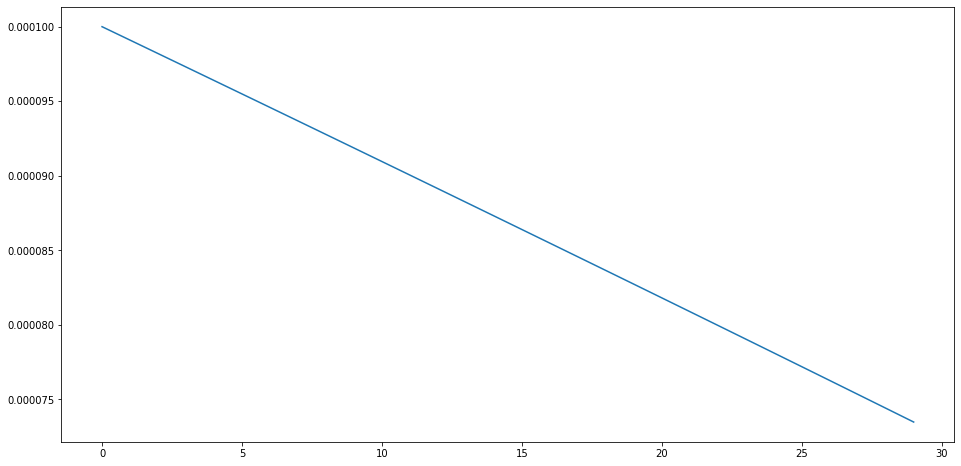

In [11]:
stage = [i for i in range(0,30)]
lr_plot = [scheduler_3(x) for x in stage]
plt.plot(stage, lr_plot)
print(lr_plot)

In [12]:
smooth = K.epsilon()
threshold = 0.8
label_smoothing = 0.0
bce_weight = 0.5

def dice_coeff(y_true, y_pred):
    numerator = tf.math.reduce_sum(y_true * y_pred) + smooth
    denominator = tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + smooth
    return tf.math.reduce_mean(2.* numerator / denominator) * 448 * 448

def dice_loss(y_true, y_pred):
    return - dice_coeff(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return bce_weight * tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=label_smoothing) - dice_coeff(y_true, y_pred) 

def bce_dice_loss_try(y_true, y_pred):
    x = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=label_smoothing)
    y = -dice_coeff(y_true, y_pred)
    return x + x/(x+y)*y

def iou(y_true, y_pred):
    overlap = tf.math.logical_and((y_true > threshold),(y_pred > threshold))
    union = tf.math.logical_or((y_true > threshold),(y_pred > threshold))
    iou = (tf.cast(tf.math.count_nonzero(overlap),tf.float32) + smooth) / (tf.cast(tf.math.count_nonzero(union),tf.float32) + smooth)
    return iou

In [13]:
loss = bce_dice_loss
optimizer = tf.keras.optimizers.Adam(lr_init)
metrics = [tf.keras.metrics.BinaryCrossentropy(from_logits=False,label_smoothing=label_smoothing,dtype=tf.float32,name='bce'), dice_coeff, iou]
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [14]:
model.load_weights('../input/medical-image-segmentation-with-ce-net/model_weights.h5')

In [15]:
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler_3, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_iou',mode='max',verbose=1,patience=15,restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('temp',save_weights_only=True,monitor='val_iou',mode='max',save_best_only=True)

history = model.fit(train, batch_size=batch_size, epochs=total_epoch, callbacks=[scheduler,earlystop,checkpoint],
            validation_data=test, steps_per_epoch=int(0.8*num_files//batch_size), validation_steps=int(0.2*num_files//batch_size), shuffle=True)

Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.


2022-09-20 22:56:52.674558: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-20 22:56:58.206035: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


13/13 [==============================] - 34s 1s/step - loss: -102521272.0000 - bce: -213014.7344 - dice_coeff: 102414768.0000 - iou: 0.8137 - val_loss: -78299064.0000 - val_bce: -202428.4375 - val_dice_coeff: 78197848.0000 - val_iou: 0.7767


2022-09-20 22:57:20.197081: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:57:22.094437: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 9.909954834128343e-05.
13/13 [==============================] - 12s 886ms/step - loss: -103233680.0000 - bce: -221613.1562 - dice_coeff: 103122864.0000 - iou: 0.8360 - val_loss: -953792.1875 - val_bce: 208.4335 - val_dice_coeff: 953901.3125 - val_iou: 0.0488


2022-09-20 22:57:34.185076: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:57:34.205385: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 9.819818665965754e-05.
13/13 [==============================] - 12s 862ms/step - loss: -104682928.0000 - bce: -215262.3906 - dice_coeff: 104575304.0000 - iou: 0.8274 - val_loss: -540920.4375 - val_bce: 8765.7578 - val_dice_coeff: 545308.3125 - val_iou: 0.0114


2022-09-20 22:57:45.999790: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:57:46.046736: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 9.729590473501306e-05.
13/13 [==============================] - 12s 850ms/step - loss: -106827000.0000 - bce: -214049.8594 - dice_coeff: 106719968.0000 - iou: 0.8345 - val_loss: -191387.7969 - val_bce: 9664.2402 - val_dice_coeff: 196224.9375 - val_iou: 0.0069


2022-09-20 22:57:57.708249: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:57:57.736773: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 9.63926921258551e-05.
13/13 [==============================] - 12s 858ms/step - loss: -103437560.0000 - bce: -211808.7969 - dice_coeff: 103331656.0000 - iou: 0.7969 - val_loss: -4820539.0000 - val_bce: -23404.2793 - val_dice_coeff: 4808841.5000 - val_iou: 0.1409


2022-09-20 22:58:09.409140: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:58:09.439814: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 6/40

Epoch 00006: LearningRateScheduler setting learning rate to 9.548853816214998e-05.
13/13 [==============================] - 12s 856ms/step - loss: -107217528.0000 - bce: -216933.0469 - dice_coeff: 107109040.0000 - iou: 0.8361 - val_loss: -147230.3281 - val_bce: 10964.4355 - val_dice_coeff: 152717.6094 - val_iou: 0.0024


2022-09-20 22:58:21.001324: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:58:21.023619: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 7/40

Epoch 00007: LearningRateScheduler setting learning rate to 9.458343193786322e-05.
13/13 [==============================] - 12s 868ms/step - loss: -106046560.0000 - bce: -216809.0469 - dice_coeff: 105938168.0000 - iou: 0.8222 - val_loss: -14854401.0000 - val_bce: -91587.2891 - val_dice_coeff: 14808612.0000 - val_iou: 0.4159


2022-09-20 22:58:41.740184: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:58:41.763801: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 8/40

Epoch 00008: LearningRateScheduler setting learning rate to 9.367736230317176e-05.
13/13 [==============================] - 12s 857ms/step - loss: -107016928.0000 - bce: -215229.5625 - dice_coeff: 106909320.0000 - iou: 0.8301 - val_loss: -55711008.0000 - val_bce: -164711.1562 - val_dice_coeff: 55628652.0000 - val_iou: 0.6595


2022-09-20 22:58:53.503491: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:58:53.523112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 9/40

Epoch 00009: LearningRateScheduler setting learning rate to 9.277031785633283e-05.
13/13 [==============================] - 12s 860ms/step - loss: -107833336.0000 - bce: -219217.9844 - dice_coeff: 107723720.0000 - iou: 0.8461 - val_loss: -4042471.7500 - val_bce: -33566.4961 - val_dice_coeff: 4025693.2500 - val_iou: 0.1770


2022-09-20 22:59:14.001631: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:59:14.047387: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 10/40

Epoch 00010: LearningRateScheduler setting learning rate to 9.186228693518995e-05.
13/13 [==============================] - 12s 842ms/step - loss: -103926320.0000 - bce: -207778.0156 - dice_coeff: 103822432.0000 - iou: 0.7762 - val_loss: -581512.3125 - val_bce: 2649.2974 - val_dice_coeff: 582842.1250 - val_iou: 0.0322


2022-09-20 22:59:25.548460: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:59:25.586892: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 11/40

Epoch 00011: LearningRateScheduler setting learning rate to 9.095325760829622e-05.
13/13 [==============================] - 12s 862ms/step - loss: -110370120.0000 - bce: -217769.5469 - dice_coeff: 110261232.0000 - iou: 0.8488 - val_loss: -109773544.0000 - val_bce: -200867.8906 - val_dice_coeff: 109673120.0000 - val_iou: 0.7504


2022-09-20 22:59:37.419616: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:59:37.450388: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 12/40

Epoch 00012: LearningRateScheduler setting learning rate to 9.004321766563289e-05.
13/13 [==============================] - 12s 854ms/step - loss: -108568440.0000 - bce: -212761.2500 - dice_coeff: 108462040.0000 - iou: 0.8196 - val_loss: -110503192.0000 - val_bce: -205825.2500 - val_dice_coeff: 110400256.0000 - val_iou: 0.7442


2022-09-20 22:59:48.981838: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 22:59:49.016346: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 13/40

Epoch 00013: LearningRateScheduler setting learning rate to 8.91321546089e-05.
13/13 [==============================] - 12s 888ms/step - loss: -110869496.0000 - bce: -211589.9844 - dice_coeff: 110763696.0000 - iou: 0.8256 - val_loss: -85319384.0000 - val_bce: -202207.8125 - val_dice_coeff: 85218280.0000 - val_iou: 0.7598


2022-09-20 23:00:09.964998: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 23:00:09.987800: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 14/40

Epoch 00014: LearningRateScheduler setting learning rate to 8.822005564135439e-05.
13/13 [==============================] - 12s 842ms/step - loss: -106646776.0000 - bce: -212870.1562 - dice_coeff: 106540328.0000 - iou: 0.7983 - val_loss: -27544934.0000 - val_bce: -101321.8594 - val_dice_coeff: 27494278.0000 - val_iou: 0.4321


2022-09-20 23:00:29.947071: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 23:00:29.984521: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 15/40

Epoch 00015: LearningRateScheduler setting learning rate to 8.73069076571686e-05.
13/13 [==============================] - 12s 831ms/step - loss: -108955280.0000 - bce: -214551.4062 - dice_coeff: 108848008.0000 - iou: 0.8110 - val_loss: -13658991.0000 - val_bce: -57648.9258 - val_dice_coeff: 13630172.0000 - val_iou: 0.2764


2022-09-20 23:00:50.751654: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-09-20 23:00:50.773832: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 16/40

Epoch 00016: LearningRateScheduler setting learning rate to 8.639269723028191e-05.
13/13 [==============================] - 12s 860ms/step - loss: -111974856.0000 - bce: -213471.6406 - dice_coeff: 111868104.0000 - iou: 0.8332 - val_loss: -344137.3438 - val_bce: 8119.0884 - val_dice_coeff: 348202.0000 - val_iou: 0.0118


2022-09-20 23:01:11.001352: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


In [16]:
model.save('model.h5')
model.save_weights('model_weights.h5')

2022-09-20 23:01:11.290777: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
dataset_image_only = tf.data.Dataset.list_files('../input/finding-lungs-in-ct-data/2d_images/*.tif',shuffle=False).map(lambda x: tf.py_function(read_image,[x],[tf.float32]))
dataset_mask_only = tf.data.Dataset.list_files('../input/finding-lungs-in-ct-data/2d_masks/*.tif',shuffle=False).map(lambda x: tf.py_function(read_mask,[x],[tf.float32]))

In [18]:
take = 32
num = np.random.randint(0,num_files-take-1)

image = np.array(list(dataset_image_only.skip(num).take(take).as_numpy_iterator()))
truth = np.array(list(dataset_mask_only.skip(num).take(take).as_numpy_iterator()))
pred = model.predict(dataset_image_only.skip(num).batch(take).take(1))

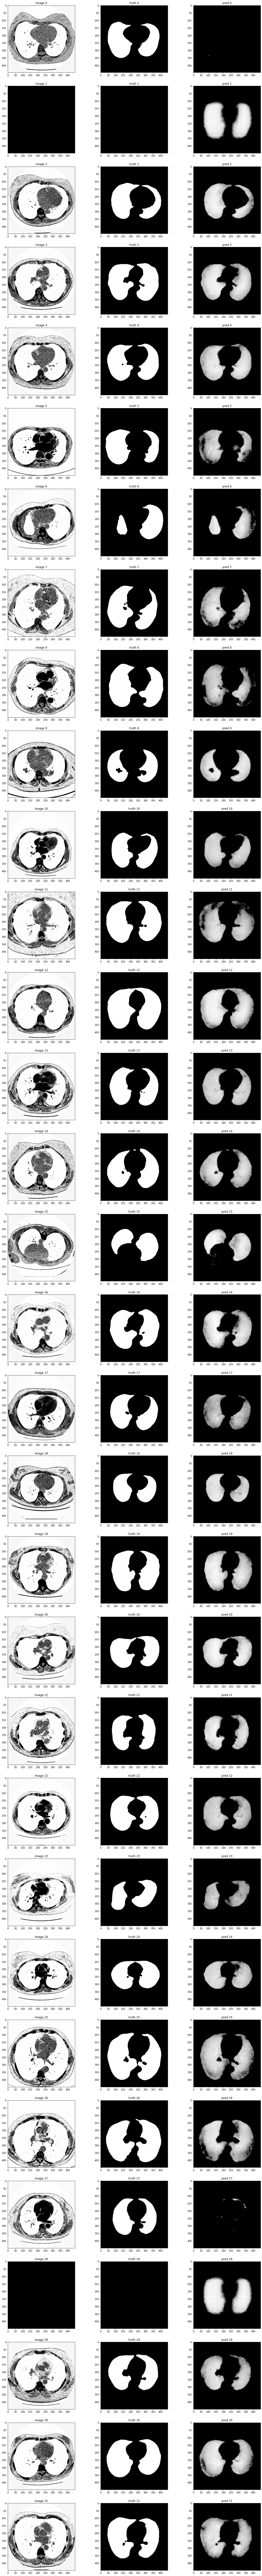

In [19]:
plt.rcParams['figure.figsize'] = [20,200]
index = 1
for i in range(take):
    plt.subplot(take,3,index)
    plt.title('image %s'%i)
    plt.imshow(image[i,0,:,:,0], cmap='gray')
    index += 1
    plt.subplot(take,3,index)
    plt.title('truth %s'%i)
    plt.imshow(truth[i,0,:,:,0], cmap='gray')
    index += 1
    plt.subplot(take,3,index)
    plt.title('pred %s'%i)
    plt.imshow(pred[i,:,:,0], cmap='gray')
    index += 1